# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Кака всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [ ]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.base import BaseEstimator

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['text', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [ ]:
class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []
        n_samples, n_features = X.shape
        self.w = self.w0 if self.w0 is not None else np.zeros(n_features)
        for i in range(self.max_iter):
            if self.gd_type == 'full':
                gradient = self.calc_gradient(X, y)
            elif self.gd_type == 'stochastic':
                random_idx = np.random.randint(0, n_samples)
                gradient = self.calc_gradient(X[random_idx:random_idx+1], y[random_idx:random_idx+1])
            prev_w = self.w.copy()
            self.w -= self.eta * gradient

            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            if np.linalg.norm(self.w - prev_w) < self.tolerance:
                print(f"Converged in {i} iterations")
                break
        return self


    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        z = X @ self.w
        return 1 / (1 + np.exp(-z))


    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return (self.predict_proba(X) >= 0.5).astype(int)

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        n_samples = X.shape[0]
        predictions = self.predict_proba(X)
        return -(1 / n_samples) * X.T @ (y - predictions)

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        predictions = self.predict_proba(X)
        return -np.mean(y * np.log(predictions + 1e-9) + (1 - y) * np.log(1 - predictions + 1e-9))

Теперь проверим работу вашего класса на синтетических данных.

In [ ]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from typing_extensions import assert_type
import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

Populating the interactive namespace from numpy and matplotlib


In [ ]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

In [ ]:
model = LogReg('full')
model.fit(X_train, y_train)
prediction = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, prediction)
precision, recall, _ = precision_recall_curve(y_test, prediction)
pr_auc = auc(recall, precision)
print("ROC-AUC=", roc_auc)
print("PR-AUC=", pr_auc)

Converged in 738 iterations
ROC-AUC= 0.9257363589480103
PR-AUC= 0.9241238453632155


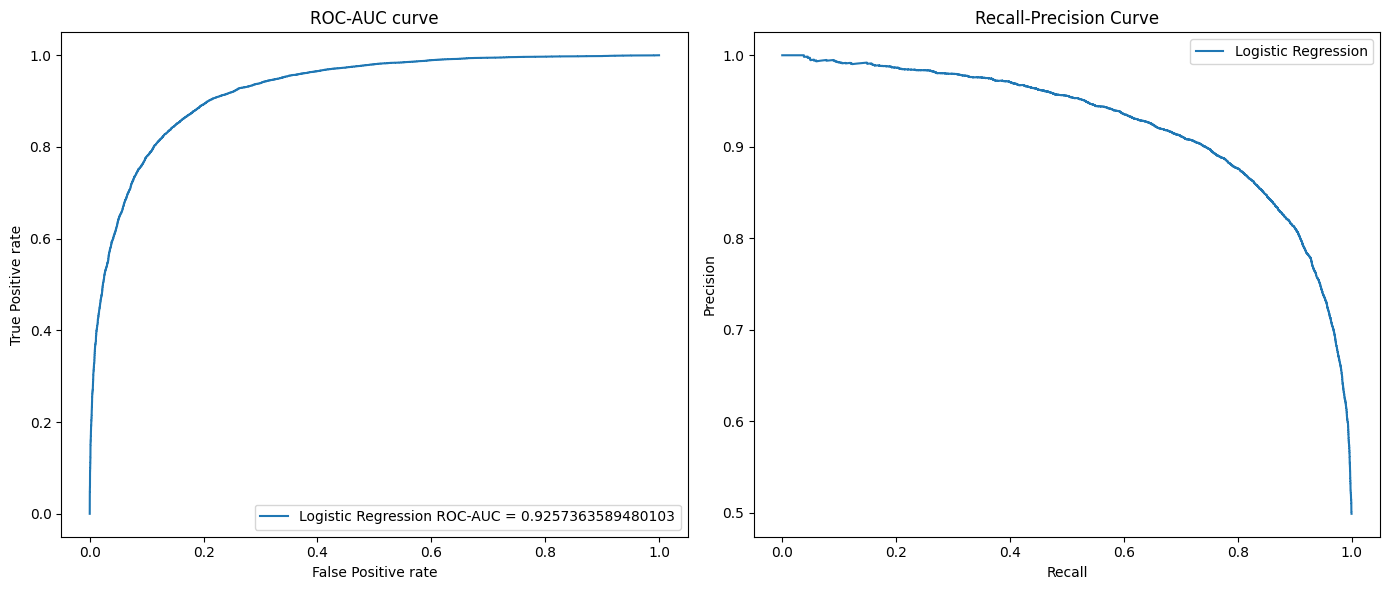

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

fpr, tpr,_ = roc_curve(y_test, prediction)
roc_auc = auc(fpr, tpr)
ax[0].plot(fpr, tpr, marker='', label=f"Logistic Regression ROC-AUC = {roc_auc}" )
ax[0].set_xlabel("False Positive rate")
ax[0].set_ylabel("True Positive rate")
ax[0].set_title("ROC-AUC curve")
ax[0].legend()

ax[1].plot(recall, precision, marker='', label="Logistic Regression")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Recall-Precision Curve")
ax[1].legend()
plt.tight_layout()
plt.show()

Площадь фигур дольно-таки большая и близка к 1, то есть качество алгоритма довольно-таки высокое.

# **Часть 2. Отбор признаков (5 баллов)**

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные** \

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [ ]:
PATH_TO_DATASET = 'train.csv'

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
target = data.target.values

data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [ ]:
col = []
for i in X_train.columns:
    if i.endswith('cat'):
        col.append(i)
X_train = pd.get_dummies(X_train, columns=col, dtype = int, drop_first=True)
X_test = pd.get_dummies(X_test, columns=col, dtype = int, drop_first=True)
missing_cols = set(X_train.columns) - set(X_test.columns)
missing_cols2 = set(X_test.columns) - set(X_train.columns)
for col in missing_cols:
    X_test[col] = 0 #добавляем в X_test столбец, если его нет
for col in missing_cols2:
    X_test.drop(col, axis=1) #удаляем если есть в X_test столбец, но нет в X_train

In [ ]:
X_train.shape

(476169, 213)

In [ ]:
X_test.shape

(119043, 213)

### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.


In [ ]:
def learning_model(model, X_train, y_train):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()-start_time
    return model, end_time

In [ ]:
logreg, end_time = learning_model(LogisticRegression(max_iter=1000), X_train, y_train)
print("Time of Logistic Regression:", end_time)
prediction_logreg = logreg.predict(X_test)
roc_auc_logreg = roc_auc_score(y_test, prediction_logreg)
print("ROC-AUC Logistic Regression", roc_auc_logreg)

Time of Logistic Regression: 107.64856886863708
ROC-AUC Logistic Regression 0.5


In [ ]:
X_train_sampled = X_train.iloc[:20000]
y_train_sampled = y_train[:20000]
svm, end_time = learning_model(SVC(), X_train_sampled, y_train_sampled)
print("Time of SVM:", end_time)

Time of SVM: 55.655354499816895


In [ ]:
prediction_svm = svm.predict(X_test)
roc_auc_svm = roc_auc_score(y_test, prediction_svm)
print("ROC-AUC SVM", roc_auc_svm)

ROC-AUC SVM 0.5


In [ ]:
knn, end_time = learning_model(KNeighborsClassifier(), X_train, y_train)
print("Time of KNN:", end_time)

Time of KNN: 2.6491963863372803


In [ ]:
prediction_knn = knn.predict(X_test)
roc_auc_knn = roc_auc_score(y_test, prediction_knn)
print("ROC-AUC KNN", roc_auc_knn)

ROC-AUC KNN 0.49998060473455247


**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

In [ ]:
def grid_search(model, parameters, X_train, y_train):
    clf = GridSearchCV(model, param_grid = parameters, scoring='roc_auc', cv=3, n_jobs=-1)
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()-start_time
    return clf, end_time

In [ ]:
parameters = {'C':[0.1, 1, 10], 'class_weight':[None, 'balanced']}
clf_logreg, end_time = grid_search(LogisticRegression(), parameters, X_train, y_train)
print("Time of GridSearchCV LogReg", end_time)
print("The best estimator LogReg", clf_logreg.best_estimator_)
print("Best ROC-AUC score during CV:", clf_logreg.best_score_)

Time of GridSearchCV LogReg 297.1800558567047
The best estimator LogReg LogisticRegression(C=1, class_weight='balanced')
Best ROC-AUC score during CV: 0.6261800278858312


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
prediction_logreg = clf_logreg.predict(X_test)
roc_auc_logreg = roc_auc_score(y_test, prediction_logreg)
print("ROC-AUC LogReg", roc_auc_logreg)

ROC-AUC LogReg 0.5998602445497568


In [ ]:
parameters = {'C':[1, 10], 'kernel':('linear', 'rbf'), 'class_weight':[None, 'balanced']}
clf_svm, end_time = grid_search(SVC(), parameters, X_train_sampled, y_train_sampled)
print("Time of GridSearchCV SVM", end_time)
print("The best estimator SVM", clf_svm.best_estimator_)
print("Best ROC-AUC score during CV:", clf_svm.best_score_)

Time of GridSearchCV SVM 10674.304007530212
The best estimator SVM SVC(C=1, class_weight='balanced')
Best ROC-AUC score during CV: 0.5748736420621369


In [ ]:
prediction_svm = clf_svm.predict(X_test)
roc_auc_svm = roc_auc_score(y_test, prediction_svm)
print("ROC-AUC SVM", roc_auc_svm)

ROC-AUC SVM 0.5735347004548161


In [ ]:
parameters = {'n_neighbors':[5, 10], 'weights': ['uniform', 'distance']}
clf_knn, end_time = grid_search(KNeighborsClassifier(), parameters, X_train, y_train)
print("Time of GridSearchCV KNN", end_time)
print("The best estimator KNN", clf_knn.best_estimator_)
print("Best ROC-AUC score during CV:", clf_knn.best_score_)

Time of GridSearchCV KNN 12019.823788404465
The best estimator KNN KNeighborsClassifier(n_neighbors=10, weights='distance')
Best ROC-AUC score during CV: 0.5176114483977372


In [ ]:
prediction_knn = clf_knn.predict(X_test)
roc_auc_knn = roc_auc_score(y_test, prediction_knn)
print("ROC-AUC KNN", roc_auc_knn)

ROC-AUC KNN 0.5


### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроеным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)

- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)




In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
logreg = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)

In [ ]:
start_time = time.time()
feature_weights = np.abs(logreg.coef_[0])
top_150_features = np.argsort(feature_weights)[-150:]
X_train_top150 = X_train.iloc[:, top_150_features]
X_test_top150 = X_test.iloc[:, top_150_features]
end_time = time.time()-start_time
print("Время отбора признаков:", end_time)

Время отбора признаков: 0.302931547164917


In [ ]:
colum150 = X_train_top150.columns
colum_standard = []
for colum in colum150:
    matches = [s for s in col if colum in s]
    if X_train_top150[colum].nunique() != 2 and not matches:
        colum_standard.append(colum)
print(f"Количество столбцов, которые нужно масштабировать: {len(colum_standard)}")
scaler = StandardScaler()
X_train_scaled = X_train_top150.copy()
X_train_scaled[colum_standard] = scaler.fit_transform(X_train_top150[colum_standard])
X_test_scaled = X_test_top150.copy()
X_test_scaled[colum_standard] = scaler.transform(X_test_top150[colum_standard])

Количество столбцов, которые нужно масштабировать: 7


In [ ]:
logreg_new = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced')
logreg_new.fit(X_train_scaled, y_train)
prediction_logreg = logreg_new.predict(X_test_scaled)
roc_auc_logreg = roc_auc_score(y_test, prediction_logreg)
print("ROC-AUC Logistic Regression", roc_auc_logreg)

ROC-AUC Logistic Regression 0.5980674528862485


### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

In [ ]:
def feature_selection(X_train, y_train, X_test, features, col):
    logreg = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced')
    logreg.fit(X_train, y_train)
    print(f"Количество признаков: {features}")
    start_time = time.time()
    feature_weights = np.abs(logreg.coef_[0])
    top_features = np.argsort(feature_weights)[-features:]
    X_train_top = X_train.iloc[:, top_features]
    X_test_top = X_test.iloc[:, top_features]
    end_time = time.time()-start_time
    print("Время отбора признаков:", end_time)
    colum = X_train_top.columns
    colum_standard = []
    for i in colum:
        matches = [s for s in col if i in s]
        if X_train_top[i].nunique() > 2 and not matches:
            colum_standard.append(i)
    print(f"Количество столбцов, которые нужно масштабировать: {len(colum_standard)}")
    scaler = StandardScaler()
    X_train_scaled = X_train_top.copy()
    X_train_scaled[colum_standard] = scaler.fit_transform(X_train_top[colum_standard])
    X_test_scaled = X_test_top.copy()
    X_test_scaled[colum_standard] = scaler.transform(X_test_top[colum_standard])
    logreg_new = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced')
    logreg_new.fit(X_train_scaled, y_train)
    prediction_logreg = logreg_new.predict(X_test_scaled)
    roc_auc_logreg = roc_auc_score(y_test, prediction_logreg)
    print("ROC-AUC Logistic Regression", roc_auc_logreg)
    return X_train_top, X_test_top

In [ ]:
X_train_top200, X_test_top200 = feature_selection(X_train, y_train, X_test, 200, col)
X_train_top150, X_test_top150 = feature_selection(X_train_top200, y_train, X_test_top200, 150, col)

Количество признаков: 200
Время отбора признаков: 1.1947684288024902
Количество столбцов, которые нужно масштабировать: 16
ROC-AUC Logistic Regression 0.5990537468677337
Количество признаков: 150
Время отбора признаков: 0.2888813018798828
Количество столбцов, которые нужно масштабировать: 8
ROC-AUC Logistic Regression 0.5964049662595408


### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другия свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [ ]:
parameters = {'C': [0.1, 1, 10]}
clf_l1, end_time = grid_search(LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000), parameters, X_train, y_train)

In [ ]:
count = 0
for i in clf_l1.best_estimator_.coef_[0]:
    if i!=0:
        count+=1
print("Количество ненулевых весов: ", count)
count = 0
for i in clf_l1.best_estimator_.coef_[0]:
    if round(i,2)!=0:
        count+=1
print("Количество ненулевых весов после округления: ", count)

Количество ненулевых весов:  129
Количество ненулевых весов после округления:  115


За один шаг получилось 129 ненулевых признаков

### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

-  Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

In [ ]:
colum_standard = []
for colum in X_train.columns:
    matches = [s for s in col if colum in s]
    if X_train[colum].nunique() > 2 and col not in col:
        colum_standard.append(colum)
print(f"Количество столбцов, которые нужно масштабировать: {len(colum_standard)}")
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[colum_standard] = scaler.fit_transform(X_train[colum_standard])
X_test_scaled = X_test.copy()
X_test_scaled[colum_standard] = scaler.transform(X_test[colum_standard])
start_time = time.time()

t_statistics = {}
for feature in colum_standard:
    class_0 = X_train_scaled[y_train == 0][feature]
    class_1 = X_train_scaled[y_train == 1][feature]

    mu_0, mu_1 = class_0.mean(), class_1.mean()
    s2_0, s2_1 = class_0.var(), class_1.var()
    n_0, n_1 = len(class_0), len(class_1)

    t_value = abs(mu_0 - mu_1) / np.sqrt((n_0 * s2_0 + n_1 * s2_1) / (n_0 + n_1))
    t_statistics[feature] = t_value

sorted_features = sorted(t_statistics, key=t_statistics.get, reverse=True)
top_features = sorted_features[:len(sorted_features) // 2]

end_time = time.time() - start_time
print(f"Feature selection completed in {end_time} seconds")

Количество столбцов, которые нужно масштабировать: 26
Feature selection completed in 14.148997783660889 seconds


In [ ]:
X_features = X_train_scaled[top_features]
model = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced')
model.fit(X_features, y_train)

y_pred_proba = model.predict_proba(X_test[top_features])[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Selected Features: {top_features}")
print(f"ROC-AUC Score: {roc_auc}")

Selected Features: ['ps_car_13', 'ps_car_12', 'ps_reg_02', 'ps_reg_03', 'ps_car_15', 'ps_reg_01', 'ps_ind_15', 'ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_car_14', 'ps_calc_03', 'ps_calc_08']
ROC-AUC Score: 0.5620924661760752


### **Методы-обёртки**

### **Задание 8 (бонус, 1 балл)**


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди каждый из признаков и смотрим, как это влияет на качество модели, обученной без удаленного признака. Удаляем признаки таким жадным способом.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур много. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 150 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
def logreg_(X_train1, y_train1, X_test1, y_test1):
    model = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced')
    model.fit(X_train1, y_train1)
    y_pred_proba = model.predict(X_test1)
    roc_auc = roc_auc_score(y_test1, y_pred_proba)
    return roc_auc

In [ ]:
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_test, y_test, test_size=0.5, random_state=120)
j=0
features = X_train.columns
X_train_without_feauter = X_train.copy()
X_test_without_feauter = X_val1.copy()
X_train_without_feauter = X_train_without_feauter.drop(features[0], axis=1)
X_test_without_feauter = X_test_without_feauter.drop(features[0], axis=1)
start_time = time.time()
roc_auc = logreg_(X_train_without_feauter, y_train, X_test_without_feauter, y_val1)
end_time = time.time() - start_time
print("Время работы жадного алгоритм на первой итерации: ", end_time)
print("Примерное время работы жадного алгоритм для всех итераций: ", end_time*X_train.shape[1])

Время работы жадного алгоритм на первой итерации:  157.76359701156616
Примерное время работы жадного алгоритм для всех итераций:  33603.64616346359


In [ ]:
def evaluate_feature_removal(X_train, y_train, X_val, y_val, model, group_size=1):
    start_time = time.time()
    scores = []
    features = X_train.columns

    feature_groups = [features[i:i + group_size] for i in range(0, len(features), group_size)]

    for group in feature_groups:
        X_train_subset = X_train.drop(columns=group)
        X_val_subset = X_val.drop(columns=group)

        model.fit(X_train_subset, y_train)
        y_val_pred = model.predict_proba(X_val_subset)[:, 1]
        score = roc_auc_score(y_val, y_val_pred)
        scores.append((score, group))

    scores.sort(reverse=True, key=lambda x: x[0])
    best_score, worst_group = scores[0]

    print(f"Удалены признаки: {worst_group} | ROC-AUC: {best_score}")
    print(f"Время итерации: {time.time() - start_time} секунд\n")

    return worst_group, best_score

In [ ]:
group_size = 5
iterations = 0
X_train_copy = X_train.iloc[:10000].copy()
y_train_copy = y_train[:10000].copy()
model1 = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced', random_state=42)
start_time = time.time()
while len(X_train_copy.columns) > 150:
    iterations += 1
    if len(X_train_copy.columns) - group_size < 150:
        group_size = len(X_train_copy.columns) - 150
    worst_group, best_score = evaluate_feature_removal(X_train_copy, y_train_copy, X_val1, y_val1, model1, group_size=group_size)
    X_train_copy = X_train_copy.drop(columns=worst_group)
    X_val1 = X_val1.drop(columns=worst_group)
    print(f"Итерация {iterations}: осталось {len(X_train_copy.columns)} признаков")
print(f"\nФинальное время отбора признаков: {time.time() - start_time} секунд")
model1.fit(X_train_copy, y_train_copy)
y_test_pred = model1.predict_proba(X_test1[X_train_copy.columns])[:, 1]
final_score = roc_auc_score(y_test1, y_test_pred)

print(f"\nФинальное качество на тесте: {final_score}")

Удалены признаки: Index(['ps_car_11_cat_82', 'ps_car_11_cat_83', 'ps_car_11_cat_84',
       'ps_car_11_cat_85', 'ps_car_11_cat_86'],
      dtype='object') | ROC-AUC: 0.5660550242767408
Время итерации: 64.30026841163635 секунд

Итерация 1: осталось 208 признаков
Удалены признаки: Index(['ps_ind_05_cat_6', 'ps_car_01_cat_0', 'ps_car_01_cat_1',
       'ps_car_01_cat_2', 'ps_car_01_cat_3'],
      dtype='object') | ROC-AUC: 0.5681666477776652
Время итерации: 65.63833236694336 секунд

Итерация 2: осталось 203 признаков
Удалены признаки: Index(['ps_car_11_cat_22', 'ps_car_11_cat_23', 'ps_car_11_cat_24',
       'ps_car_11_cat_25', 'ps_car_11_cat_26'],
      dtype='object') | ROC-AUC: 0.5700615499569376
Время итерации: 73.91292333602905 секунд

Итерация 3: осталось 198 признаков
Удалены признаки: Index(['ps_car_11_cat_52', 'ps_car_11_cat_53', 'ps_car_11_cat_54',
       'ps_car_11_cat_55', 'ps_car_11_cat_56'],
      dtype='object') | ROC-AUC: 0.5718904621299497
Время итерации: 50.59168004989624 

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

При обучении моделей с дефолтными параметрами были вычислены ROC-AUC для трех моделей, которые были равны 0.5 и также получены время работы каждого из методов:

1) Самый быстрый: KNN

2) Средний: SVM

3) Самый медленный LogisticRegression

Далее были подобраны гиперпараметры с помощью GridSearchCV и ROC-AUC изменился:
Для логичтиеской регрессии стал 0.6
Для метода опорных вектор стал 0.57
Для метода k ближайших соседей стал: 0.52

То есть можно сделать вывод, что качество логистической регрессии выше, чем у SVM и KNN. Также подбор гиперпараметров для логистической регрессии был быстрее, на втором месте SVM, а на 3 KNN.

Далее были выбраны 150 признаков с наибольшими по модулю весами и после была обучена модель логистическое регрессия с данными признаками. ROC-AUC при этом практически не изменился и время было равно 0.3

После был выполнен постепенный отбор признаков, а именно сначала 200, а затем 150. И в этом случае для 200 - 1.2 секунды длилось обучения, а для 150 - 0,29 с, качество незначительно ухудшилось.

Далее была применена t стастика, при которой качество ухудшилось, а скорость уменьшилась.

После был применен жадный алгоритм при котором была самая медленная скорость, но при этом качество лучше, чем при применении t-статистики

**Выводы**

Сортировка по времени методы:

1) 150 признаков с наибольшими по модулю весами

2) 200, а затем 150

3) t-статистика

4) Жадный алгоритм

По качеству:

1) 150 признаков с наибольшими по модулю весами

2) 200, а затем 150

3) Жадный алгоритм

4) t-статистика

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [ ]:
from sklearn.model_selection import train_test_split

PATH = 'train.csv'
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
data.fillna('', inplace=True)

- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [ ]:
print("количество уникальных значений target", data['target'].nunique())
print("количество уникальных значений id", data['id'].nunique())

количество уникальных значений target 2
количество уникальных значений id 7613


Можно сделать вывод, что столбец id можно удалить, так как это просто номер строки.

А по столбцу target можно сделать вывод, что испольузется два класса.

In [ ]:
data = data.drop('id', axis=1)

- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

In [ ]:
data['target'].value_counts()

,count
target,
0,4342
1,3271


Соотношение классов хорошее, так как в кажддом классе количество близко к половине. В ином случае, если один класс доминирует, модель может схитрить, предсказывая в основном этот класс, чтобы минимизировать общую ошибку.

- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [ ]:
data['concut_text'] = data['keyword'] + ' ' + data['location'] + ' ' + data['text']

- Наконец, поделите данные на тренировочную и тестовую выборки.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['concut_text'], data['target'], test_size=0.25, random_state = 42)

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
cnt_vec = CountVectorizer()
bow = cnt_vec.fit_transform(X_train)
bow_test = cnt_vec.transform(X_test)
bow.shape

(5709, 19370)

- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [ ]:
start_time = time.time()
clf = LogisticRegression(max_iter=200, random_state=42)
end_time = time.time() - start_time
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print("Время: ", end_time)
print(f1_score(y_test, pred))

Время:  0.00016069412231445312
0.7546444586803331


- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [ ]:
svm = SVC()
start_time = time.time()
svm.fit(bow, y_train)
end_time = time.time() - start_time
pred_svm = svm.predict(bow_test)
print("Время: ", end_time)
print(f1_score(y_test, pred_svm))

Время:  8.894054412841797
0.7482900136798906


Логистическая регрессия более быстрая, чем SVC и качество незначительно лучше

### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

In [ ]:
f1_logreg_0 = f1_score(y_test, pred)
f1_svm_0 = f1_score(y_test, pred_svm)
best_f1_logreg = 0
best_f1_svm = 0
best_params_logreg = None
best_params_svm = None
target_feature_limit = 5709 // 4
tolerance = 0.07
for min_df in range(5, 20):
    for max_df in np.arange(0.1, 1, 0.2):
        max_df = round(max_df, 1)
        cnt_vec = CountVectorizer(min_df=min_df, max_df=max_df)
        bow = cnt_vec.fit_transform(X_train)
        bow_test = cnt_vec.transform(X_test)
        if bow.shape[1] > target_feature_limit:
            continue

        clf = LogisticRegression(max_iter=200, random_state=42)
        clf.fit(bow, y_train)
        pred_logreg = clf.predict(bow_test)
        f1_logreg = f1_score(y_test, pred_logreg)

        svm = SVC(random_state=142)
        svm.fit(bow, y_train)
        pred_svm = svm.predict(bow_test)
        f1_svm = f1_score(y_test, pred_svm)

        if abs(f1_logreg - f1_logreg_0) <= tolerance and f1_logreg > best_f1_logreg:
            best_f1_logreg = f1_logreg
            best_params_logreg = {'min_df': min_df, 'max_df': max_df}
        if abs(f1_svm - f1_svm_0) <= tolerance and f1_svm > best_f1_svm:
            best_f1_svm = f1_svm
            best_params_svm = {'min_df': min_df, 'max_df': max_df}

print(f"Best parameters LogReg: {best_params_logreg}")
print(f"Best F1 score LogReg: {best_f1_logreg}")
print(f"Best parameters SVM: {best_params_svm}")
print(f"Best F1 score SVM: {best_f1_logreg}")

Best parameters LogReg: {'min_df': 19, 'max_df': 0.3}
Best F1 score LogReg: 0.7547649301143583
Best parameters SVM: {'min_df': 11, 'max_df': 0.1}
Best F1 score SVM: 0.7547649301143583


Данные параметры отвечают за отбрасывание признаков, которые слишком часто встрчеаются(max_df) и очень редко(min_df). То есть, например, для логисической регрессии слова которые встрчеются в 30% документов и более отбрасываются и отбрасываются также слова, которые появляются менее, чем в 19 документах

### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
cnt_vec = CountVectorizer(min_df = 19, max_df = 0.3)
bow = cnt_vec.fit_transform(X_train)
bow_test = cnt_vec.transform(X_test)
bow.shape

(5709, 817)

In [ ]:
parameters = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear'], 'max_iter': [200, 300 ,500]}
clf = GridSearchCV(LogisticRegression(max_iter=200), parameters, scoring='f1', cv=3)
clf.fit(bow, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=200),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [200, 300, 500],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='f1')

In [ ]:
clf = LogisticRegression(C=1, max_iter=200, random_state=42, solver='liblinear')
clf.fit(bow, y_train)
pred_logreg = clf.predict(bow_test)
f1_logreg = f1_score(y_test, pred_logreg)
print("f1 Logreg", f1_logreg)

f1 Logreg 0.7523870146403565


1) C (регуляризация):
Чем меньше C, тем сильнее регуляризация (упрощение модели).
Диапазон: [0.1, 1, 10].

2) solver (алгоритм оптимизации):

*   liblinear: для небольших данных, поддерживает l1 и l2.
*   lbfgs: хорошо работает для l2, но не поддерживает l1.

3) max_iter:
Увеличивает максимальное количество итераций для сходимости.
Диапазон: [100, 200, 500].

Результаты:
C=1, max_iter=200, solver='liblinear'

1) Регуляризация сбалансирована

2) Модель сойдётся даже на больших наборах данных

3) liblinear отлично подходит для маленьких или средних наборов данных и поддерживает регуляризацию l1 и l2.


- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
cnt_vec = CountVectorizer(min_df = 11, max_df = 0.1)
bow = cnt_vec.fit_transform(X_train)
bow_test = cnt_vec.transform(X_test)
bow.shape

(5709, 1287)

In [ ]:
parameters = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
clf = GridSearchCV(SVC(), parameters, scoring='f1', cv=3, n_jobs=-1)
clf.fit(bow, y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             scoring='f1')

In [ ]:
svm = SVC(C=0.1, kernel='linear')
svm.fit(bow, y_train)
pred_svm = svm.predict(bow_test)
f1_svm = f1_score(y_test, pred_svm)
print("f1 SVM", f1_svm)

f1 SVM 0.7315123251165889


kernel - тип ядра, то есть линия которая разделяет данные

Результаты: C=0.1, kernel='linear'

1) C=0.1 слабая регулризация, то есть модель может незначительно ошибаться и менее подвержена переобучению

2) Данные разделяются прямой линией

### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [ ]:
from sklearn.pipeline import Pipeline

pipe_logreg = Pipeline([
                 ('vectorize', CountVectorizer(min_df = 19, max_df = 0.3)),
                 ('model', LogisticRegression(C=1, max_iter=200, random_state=42, penalty = 'l2'))
                ])
pipe_logreg.fit(X_train, y_train)
pred_logreg = pipe_logreg.predict(X_test)
print("f1 LogReg", f1_score(y_test, pred_logreg))

pipe_svm = Pipeline([
                 ('vectorize', CountVectorizer(min_df = 11, max_df = 0.1)),
                 ('model', SVC(C=0.1, kernel='linear'))
                ])
pipe_svm.fit(X_train, y_train)
pred_svm = pipe_svm.predict(X_test)
print("f1 SVC", f1_score(y_test, pred_svm))

f1 LogReg 0.7547649301143583
f1 SVC 0.7315123251165889


### **Выводы**

Зафиксируйте выводы работы. Проанализируйте, что проделано и какие результаты вы получили. Заполняется в свободной форме.

Было сделано:

1) Базовая предобработка

2) Обучение логистическая регрессия и SVC на сырых данных(логистическая регрессия и по качество, и по скорости лучше)

3) Подбор гиперпараметров CountVectorizer (уменьшение количества признаков для логистической регрессии с 19370 до 817, а в SVC с 19370 до 1287)

4) Подбор гиперпараметры для обучения логистической регрессии и SVM (качество слегка ухудшилось)

5) Оформление двух пайплайна

**Итоговые гиперпараметры CountVectorizer:**

Best parameters LogReg: {'min_df': 19, 'max_df': 0.3}

Best F1 score LogReg: 0.7547649301143583

Best parameters SVM: {'min_df': 11, 'max_df': 0.1}

Best F1 score SVM: 0.7547649301143583

**Итоговые гиперпараметры LogisticRegression:**

LogisticRegression(C=1, max_iter=200, solver='liblinear')

**Итоговые гиперпараметры SVC:**

SVC(C=0.1, kernel='linear')

**Итоговые значения f1:**

f1 LogReg 0.7547649301143583
f1 SVC 0.7315123251165889


Я думаю, что это кот Елены

## Чей кот?

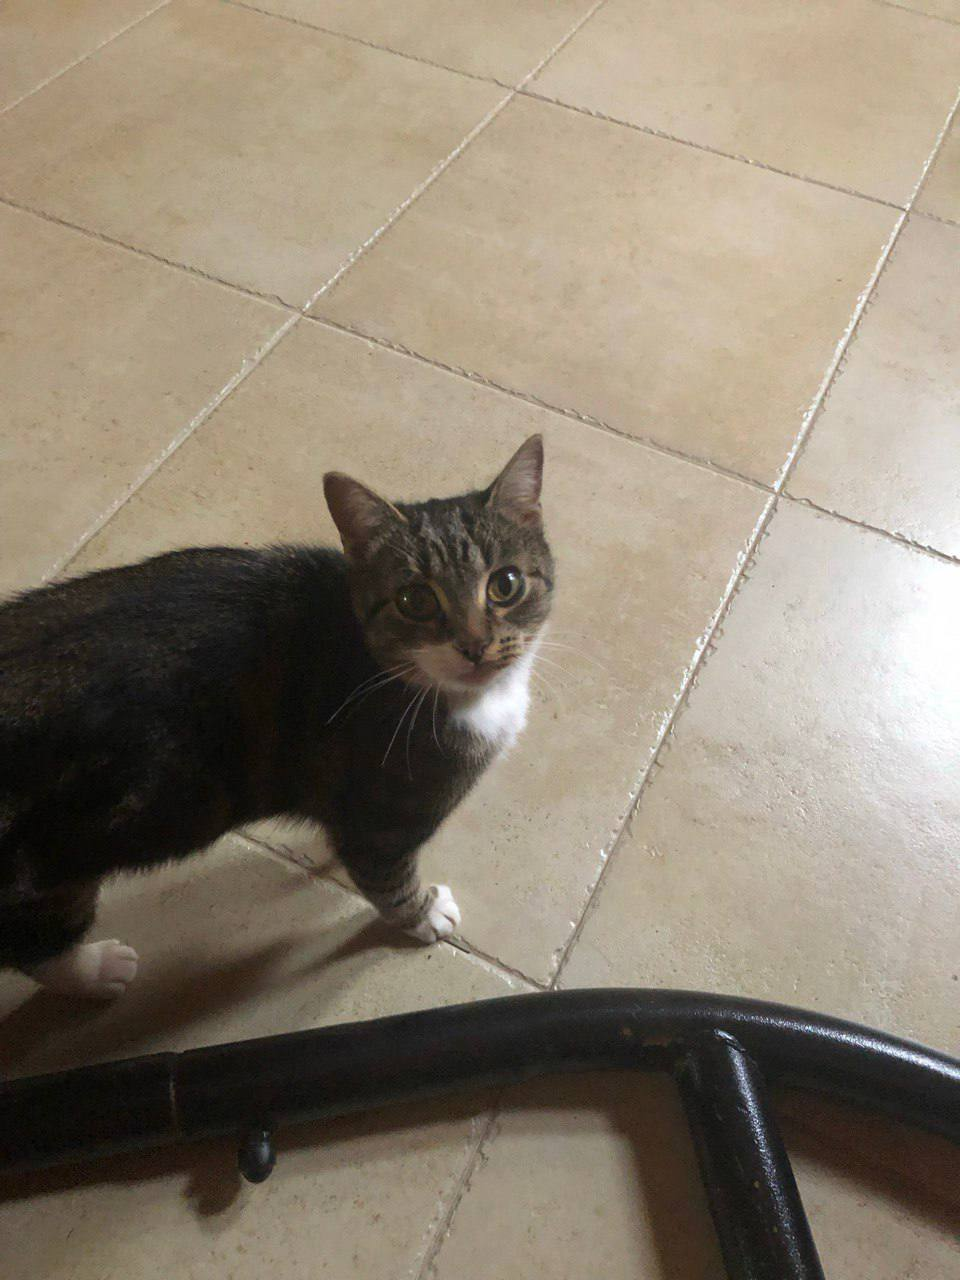